In [1]:
import spacy
import textacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd
from textblob import TextBlob
import datetime
import truecase

In [2]:
#import headline csv
#csv columns of interest are headline, date, president
df= pd.read_csv('allfinals.csv') 
headlines = [[x,y,z,a] for x, y,z,a in zip(df['date'], df['headline'],df['pres'], df['material_type'])]

In [5]:
df.head()

,Unnamed: 0,date,doc_type,headline,keywords,material_type,pres,section,web_url
0,4,2018-12-01,article,Trump Fund-Raiser Received Laundered Foreign M...,"['Presidential Election of 2016', 'United Stat...",News,trump,NaN,https://www.nytimes.com/2018/11/30/us/politics...
1,9,2018-12-01,article,Trump Administration Peppers Inboxes With Plug...,"['Health Insurance and Managed Care', 'Medicar...",News,trump,NaN,https://www.nytimes.com/2018/12/01/us/politics...
2,10,2018-12-01,article,Trump Tops Tricky Dick,['Russian Interference in 2016 US Elections an...,Op-Ed,trump,NaN,https://www.nytimes.com/2018/11/30/opinion/don...
3,12,2018-12-02,article,‘S.N.L.’ Has Alec Baldwin and Ben Stiller Play...,['Television'],News,trump,NaN,https://www.nytimes.com/2018/12/02/arts/televi...
4,13,2018-12-04,article,"Trump Warns China That He’s ‘Tariff Man,’ Spoo...","['United States Economy', 'Government Bonds', ...",News,trump,NaN,https://www.nytimes.com/2018/12/04/business/yi...


In [3]:
#building two new datatables
#one is for the headline stats including headline length, pos counts, date and pres
tokenlist=[]
headlinelist=[]

for headline in headlines:
    headline_d={}

    headline_text=truecase.get_true_case(headline[1])
    date=headline[0]
    pres=headline[2]
    section=headline[3]

    doc=nlp(headline_text)

    words=[w for w in list(doc)]
    headline_d['length']=len([w for w in list(doc) if w.is_alpha])
    headline_d['nounct'] = len([w for w in words if w.pos_ == "NOUN"])
    headline_d['verbct'] = len([w for w in words if w.pos_ == "VERB"])
    headline_d['adjct'] = len([w for w in words if w.pos_ == "ADJ"])
    headline_d['advct'] = len([w for w in words if w.pos_ == "ADV"])  
    headline_d['date']=date
    headline_d['pres']=pres
    headline_d['section']=section

    #getting readability stats using textacy library
    #https://textacy.readthedocs.io/

    ts = textacy.TextStats(doc)
    headline_d['syllables']=ts.n_syllables
    headline_d['chars']=ts.n_chars
    #headline_d['entropy']=ts.entropy
    headline_d['grade_level']=ts.flesch_kincaid_grade_level
    headline_d['flesch']=ts.flesch_reading_ease
    headline_d['lix']=ts.lix

    #getting sentiment analysis scores
    headline_blob=TextBlob(headline_text)
    headline_d['polarity']=headline_blob.sentiment.polarity
    headline_d['subjectivity']=headline_blob.sentiment.subjectivity


   
    headline_d['headline']=headline_text
    i=0
    for i in range(len(words)+1):
        word_d={}
        word_d['token']=words[i-1].text.lower()
        word_d['lemma']=words[i-1].lemma_
        word_d['pos']=words[i-1].pos_
        if i-2>=0:
            word_d['prev_word']=words[i-2].text.lower()
        if i!=0 and i!=len(words):
            word_d['bigram']=words[i-1].text.lower() + " " + words[i].text.lower()
        word_d['pres']=pres
        word_d['date']=date
    
        tokenlist.append(word_d)
        i+=1

    headlinelist.append(headline_d)

In [6]:
token_df=pd.DataFrame(tokenlist) 
doc_df=pd.DataFrame(headlinelist)

In [7]:
doc_df.head()

,adjct,advct,chars,date,flesch,grade_level,headline,length,lix,nounct,polarity,pres,section,subjectivity,syllables,verbct
0,2,0,58,2018-12-01,37.900000,10.208889,Trump fund-raiser received laundered foreign m...,9,53.444444,4,-0.125,trump,News,0.125,17,3
1,2,0,65,2018-12-01,35.945000,10.730000,Trump administration Peppers Inboxes with plug...,10,60.000000,4,0.000,trump,News,0.375,19,0
2,2,0,19,2018-12-01,118.175000,-2.230000,Trump tops tricky Dick,4,4.000000,1,0.000,trump,Op-Ed,0.000,4,0
3,0,0,57,2018-12-02,95.939286,3.355714,‘ S. N. L. ’ has Alec Baldwin and Ben Stiller ...,11,35.428571,0,0.000,trump,News,0.000,16,1
4,0,0,53,2018-12-04,80.306364,4.790909,"Trump WARNS China that he ’ s ‘ tariff man, ’ ...",11,29.181818,5,0.000,trump,News,0.000,15,4


In [8]:
#make new column for year
def getyear(date):
    #first four numbers in date column are year
    return int(date[0:4])

doc_df['year']=doc_df['date'].apply(getyear)

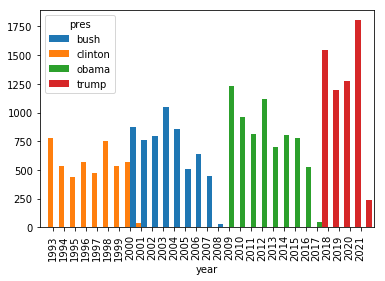

In [10]:
#calculating the count of headlines for each sitting president
%matplotlib inline
count_headlines = doc_df.pivot_table(values="headline", index="year", columns="pres", aggfunc=pd.Series.nunique)
count_headlines.plot(kind='bar',width=2.0)


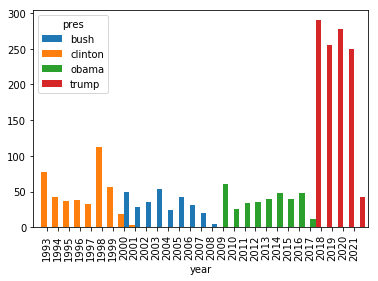

In [11]:
%matplotlib inline
opinion_list=['Op-Ed', 'Editorial', 'Opinion', 'Editorial; Letter','Letter']
count_opinion=doc_df[doc_df['section'].isin(opinion_list)].pivot_table(values="headline", index="year", columns="pres", aggfunc=pd.Series.nunique)
count_opinion.plot(kind='bar',width=2.0)